In [1]:
import time
t1 = time.time()

import pylhe
import ROOT
import math
import numpy as np
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.20/04


In [2]:
def M(p1):
    return math.sqrt(sum((1 if index=='e' else -1)*(getattr(p1,index))**2 for index in ['e','px','py','pz']))
def pT(p1):
    return math.sqrt(sum((getattr(p1,index))**2 for index in ['px','py']))
def phi(p1):
    return math.atan(p1.py/p1.px)
def eta(p1):
    return math.asinh(p1.pz/pT(p1))

In [3]:
path = '/data/Chen-Wang/mucollider/muzhh/Events/run_01/unweighted_events.lhe'
muhh_events = pylhe.readLHE(path)

In [4]:
events = []
h1_M, h2_M = [], []
h1_pT, h2_pT = [], []
h1_eta, h2_eta = [], []
h1_phi, h2_phi = [], []

for event in muhh_events:
    events.append(event)
#     h1_M.append(M(event.particles[2]))
    h2_M.append(M(event.particles[3]))
#     h1_pT.append(pT(event.particles[2]))
    h2_pT.append(pT(event.particles[3]))
#     h1_eta.append(eta(event.particles[2]))
    h2_eta.append(eta(event.particles[3]))
#     h1_phi.append(phi(event.particles[2]))
    h2_phi.append(phi(event.particles[3]))

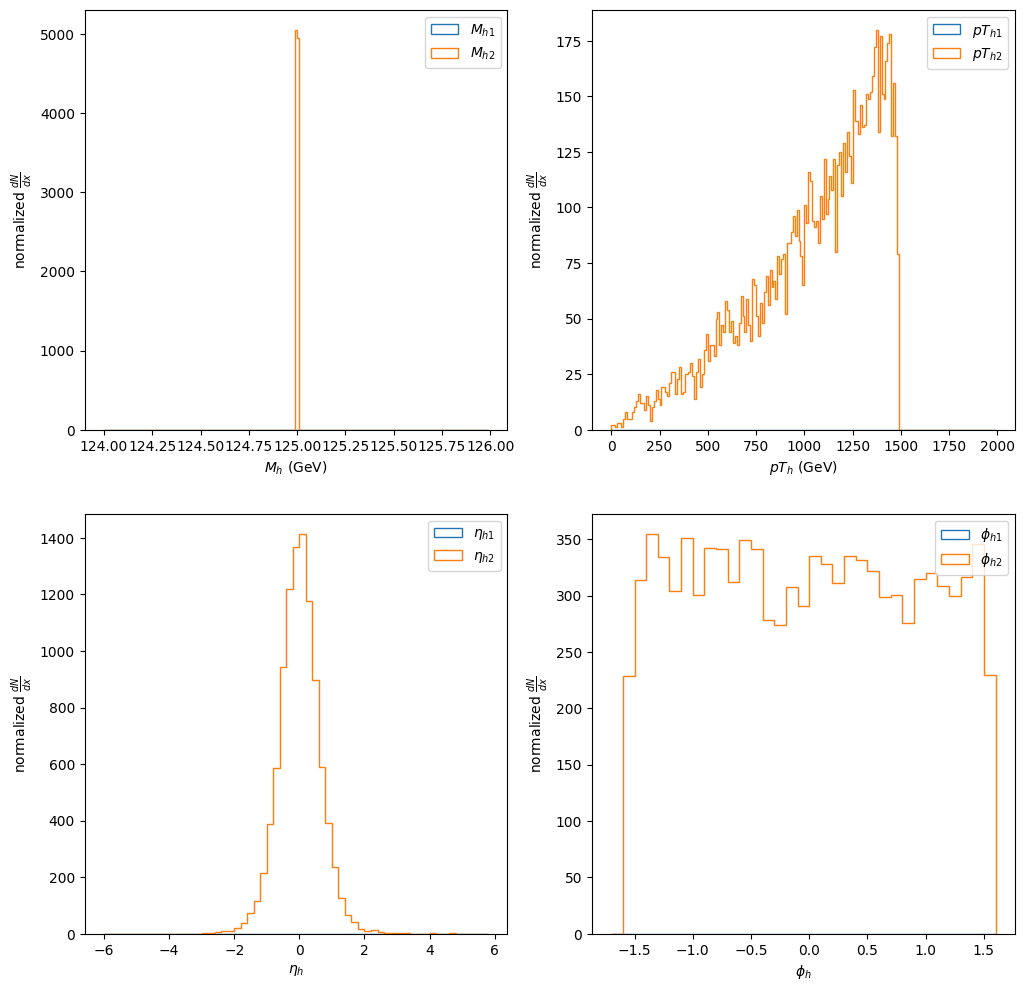

In [5]:
fig = plt.figure(figsize=(12, 12))

fig.add_subplot(221)
bins = np.arange(124,126,0.01)
plt.hist(h1_M, bins=bins, label=r"$M_{h1}$", histtype='step')
plt.hist(h2_M, bins=bins, label=r"$M_{h2}$", histtype='step')
plt.xlabel(r"$M_{h} ~\rm{(GeV)}$", fontsize=10)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=10)
plt.legend()

fig.add_subplot(222)
bins = np.arange(0, 2000,10)
plt.hist(h1_pT, bins=bins, label=r"$pT_{h1}$", histtype='step')
plt.hist(h2_pT, bins=bins, label=r"$pT_{h2}$", histtype='step')
plt.xlabel(r"$pT_{h} ~\rm{(GeV)}$", fontsize=10)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=10)
plt.legend()

fig.add_subplot(223)
bins = np.arange(-6, 6,0.2)
plt.hist(h1_eta, bins=bins, label=r"$\eta_{h1}$", histtype='step')
plt.hist(h2_eta, bins=bins, label=r"$\eta_{h2}$", histtype='step')
plt.xlabel(r"$\eta_{h}$", fontsize=10)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=10)
plt.legend()

fig.add_subplot(224)
bins = np.arange(-1.7, 1.7,0.1)
plt.hist(h1_phi, bins=bins, label=r"$\phi_{h1}$", histtype='step')
plt.hist(h2_phi, bins=bins, label=r"$\phi_{h2}$", histtype='step')
plt.xlabel(r"$\phi_{h}$", fontsize=10)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=10)
plt.legend()

plt.show()

In [6]:
print("{:^12}{:^9}{:^12}{:^12}{:^12}{:^12}{:^12}{:^12}{:^12}".format("#","id","mother1","mother2","e","px","py","pz","status"))

for i, element in  enumerate(events[1].particles):
    print("{:^12}{:^9.0f}{:^12.0f}{:^12.0f}{:^12.3f}{:^12.3f}{:^12.3f}{:^12.3f}{:^12.0f}".format(i, element.id,element.mother1,element.mother2,element.e,element.px,element.py,element.pz,element.status))

     #         id      mother1     mother2        e           px          py          pz        status   
     0         -13        0           0        1500.000     0.000       0.000      1500.000       -1     
     1         13         0           0        1500.000     -0.000      -0.000    -1500.000       -1     
     2         23         1           2        242.137     188.385     121.761      -0.738        1      
     3         25         1           2        1286.762    1266.726    -79.866     -170.757       1      
     4         25         1           2        1471.101   -1455.111    -41.896     171.495        1      


In [7]:
dir(events[0].particles[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'color1',
 'color2',
 'e',
 'event',
 'fieldnames',
 'fromstring',
 'id',
 'lifetime',
 'm',
 'mother1',
 'mother2',
 'mothers',
 'px',
 'py',
 'pz',
 'spin',
 'status']

In [8]:
print("Time:{:^8.4f}(s)".format(time.time()-t1))

Time: 2.7801 (s)
